<h1><center>A "Crude" Approach to Predicting Crude Oil Futures</center></h1>

### The data for this analysis was downloaded from [Investing.com](https://www.investing.com/).

### The data includes the following:

    1. Date - Daily based on Business Days
    2. Price - Daily Closing Price
    3. Open - Daily Opening Price
    4. High - Intraday Maximum Price
    5. Low - Intraday Minimum Price
    6. Volume - # of futures traded
    7. % Change - Percent change from previous day's closing price
    
Both the West Texas Intermediate Crude Oil and Brent Crude Oil Prices are from the [New York Mercantile Exchange](https://en.wikipedia.org/wiki/New_York_Mercantile_Exchange).

Please see accompanying blog post at [SalCorpEnterprise](https://salcorpenterprise.com).

Disclaimer: Do not make investment decisions based on the predictions/forecast presented in this model.  This is a very simplistic and crude approach to predicting crude oil prices.  There is much more that goes into the price movement of both of these commodities.  Do your own research before making ANY investment decisions!

In [1]:
# Importing libraries used for the analysis
import pandas as pd
import numpy as np

import plotly.offline as pyo
import plotly.graph_objs as go

# Using latest version of statsmodel 0.9.0 (otherwise get errors during SARIMAX fit)
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
%matplotlib inline

# Not recommended, but using these to keep a clean notebook. Warnings will most likely occur during SARIMAX
# fit due to frequency errors (i.e. data is not sequential by day since futures are not traded in the United States
# on weekends and holidays)
import warnings
warnings.filterwarnings("ignore")

### West Texas Intermediate Futures Predictions

In [2]:
# Read in historical data for visualization
# There are two files because Investing.com seems to have a limit to how many rows you can download.
history = pd.read_csv('./data/Crude Oil WTI Futures Historical Data.csv')
history2 = pd.read_csv('./data/Crude Oil WTI Futures Historical Data2.csv')

In [3]:
# Append the two above dateframes together
historical_data = history2.append(history)

# Set Date column to datetime for time series
historical_data['Date'] = pd.to_datetime(historical_data['Date'], format = '%b %d, %Y')

# Data file is sorted from most recent date to the past so sorting by date to go the other way around
historical_data = historical_data.sort_values(by='Date', ascending=True)

# Resetting the index due to the sort_value change
historical_data = historical_data.reset_index(drop = True)

# Dropping all columns except for the Closing Price
historical_data = historical_data.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])

# Setting the Date as the index
historical_data = historical_data.set_index('Date')

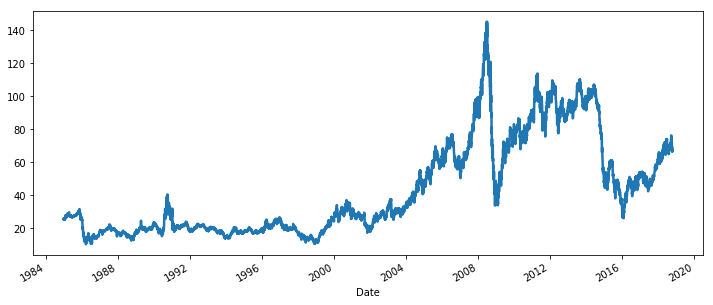

In [4]:
# Simple plot of historical data
historical_data['Price'].plot(lw=2.5, figsize=(12,5));

In [5]:
# Plotly graph of entire dataset from 1985
trace = go.Scatter(x=historical_data.index,
                       y=historical_data['Price'],
                       mode='lines')
data = [trace]

layout = go.Layout(
    title = 'West Texas Intermediate (WTI) Crude Oil Futures from 1985',
    xaxis = dict(title = 'Date'),
    yaxis = dict(title = 'Price ($)')
) 

fig = go.Figure(data = data, layout = layout)

pyo.plot(fig)

'file://C:\\Users\\aggie\\Projects\\Stock_Trading\\temp-plot.html'

In [6]:
# Grabbing data from January 1st, 2016
df = historical_data.loc['2016-01-01':]

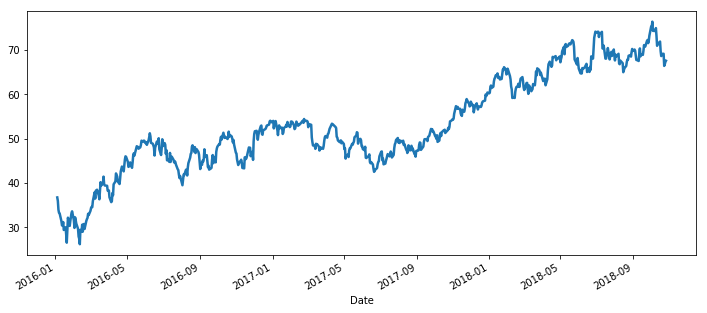

In [7]:
# Simple plot of data from January 2016
df['Price'].plot(lw=2.5, figsize=(12,5));

In [8]:
# Plotly graph of entire dataset from January 1st, 2016
trace = go.Scatter(x=df.index,
                       y=df['Price'],
                       mode='lines')
data = [trace]

layout = go.Layout(
    title = 'West Texas Intermediate (WTI) Crude Oil Futures from January, 2016',
    xaxis = dict(title = 'Date'),
    yaxis = dict(title = 'Price ($)')
) 

fig = go.Figure(data = data, layout = layout)

pyo.plot(fig)

'file://C:\\Users\\aggie\\Projects\\Stock_Trading\\temp-plot.html'

Using code from [How to Grid Search ARIMA Model Hyperparameters with Python](https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/), the optimal p, d, q values are found based on Mean Squared Error from doing a train-test-split on the data.  They are (0, 1, 0).

In [9]:
%%time

# Instantiating the model using SARIMAX, the optimal p, d, q values, and a seasonal order based on 365 days/year.
model = sm.tsa.statespace.SARIMAX(df['Price'],
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 0, 365),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

# Fitting the model
SARIMAX_results = model.fit()

Wall time: 8min 27s


In [10]:
# Getting model's predictions of the in-sample data, rounding to two decimal places for price.
SARIMAX_predictions = round(SARIMAX_results.predict(), 2)

# Creating a dataframe of the date index and predictions
SARIMAX_preds = pd.DataFrame(list(zip(list(SARIMAX_predictions.index),list(SARIMAX_predictions))),
                             columns=['Date','PredictedPrice']).set_index('Date')

# Merging the original dataframe with predictions for comparison
SARIMAX_predicted_df = pd.merge(df[1:], SARIMAX_preds, left_index=True, right_index=True)

SARIMAX_predicted_df.head()

,Price,PredictedPrice
Date,,
2016-01-05,35.97,36.76
2016-01-06,33.97,35.97
2016-01-07,33.27,33.97
2016-01-08,33.16,33.27
2016-01-11,31.41,33.16


Calculating Mean Squared Error as well as Root Mean Squared Error

In [11]:
print("\tMean Squared Error:", mean_squared_error(SARIMAX_predicted_df['Price'], 
                                                  SARIMAX_predicted_df['PredictedPrice']))
print("\tRoot Mean Squared Error:", np.sqrt(mean_squared_error(SARIMAX_predicted_df['Price'], 
                                                               SARIMAX_predicted_df['PredictedPrice'])))

	Mean Squared Error: 1.910275403225806
	Root Mean Squared Error: 1.3821271299073057


Making a forecast dataframe from 10/29/2018 to 4/14/2019

In [12]:
# Getting 120 days (a little more than 6 months in business days) for forecasts
SARIMAX_forecast = round(SARIMAX_results.forecast(steps = 120), 2)

# Creating an index from 10/29/2018 to six months out, frequency indicates business day which eliminates weekends and
# US holidays, then putting it all together into a SARIMAX_forecast dataframe
idx = pd.date_range('2018-10-29', '2019-04-14', freq='B')

SARIMAX_forecast = pd.DataFrame(list(zip(list(idx),list(SARIMAX_forecast))),
                             columns=['Date','ForecastPrice']).set_index('Date')

SARIMAX_forecast.head()

,ForecastPrice
Date,
2018-10-29,67.78
2018-10-30,68.03
2018-10-31,68.41
2018-11-01,66.68
2018-11-02,66.41


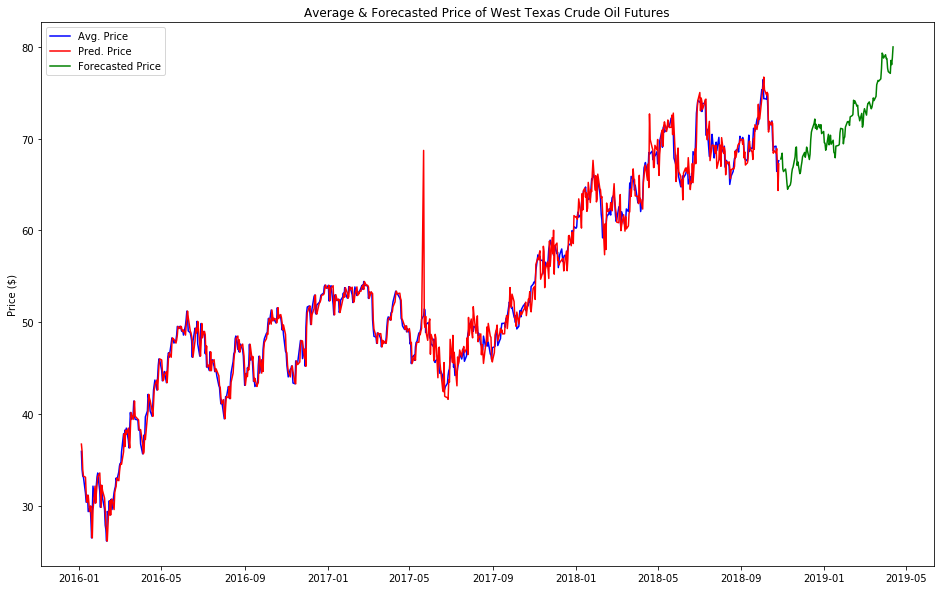

In [13]:
# Matplotlib Plot for Notebook

fig=plt.figure(figsize=[16,10])
fig.show()
ax=fig.add_subplot(111)

ax.plot(SARIMAX_predicted_df['Price'],c='b',label='Avg. Price')
ax.plot(SARIMAX_predicted_df['PredictedPrice'],c='r', label='Pred. Price')
ax.plot(SARIMAX_forecast['ForecastPrice'],c='g', label='Forecasted Price')

plt.legend(loc='best')
plt.ylabel('Price ($)')
plt.title('Average & Forecasted Price of West Texas Crude Oil Futures')
plt.draw()

In [14]:
# Plotly Code for Blog Post
trace0 = go.Scatter(
    x = SARIMAX_predicted_df.index,
    y = SARIMAX_predicted_df['Price'],
    mode = 'lines',
    name = 'Daily Price'
)
trace1 = go.Scatter(
    x = SARIMAX_predicted_df.index,
    y = SARIMAX_predicted_df['PredictedPrice'],
    mode = 'lines',
    name = 'Predicted Price'
)
trace2 = go.Scatter(
    x = SARIMAX_forecast.index,
    y = SARIMAX_forecast['ForecastPrice'],
    mode = 'lines',
    name = 'Forecast Price'
)
data = [trace0, trace1, trace2]

layout = go.Layout(
    title = 'SARIMAX Model: Daily & 6-Month Forecast Price of West Texas Intermediate (WTI) Crude Oil Futures from 2016',
    xaxis = dict(title = 'Date'),
    yaxis = dict(title = 'Price ($)')
) 

fig = go.Figure(data = data, layout = layout)

pyo.plot(fig)

'file://C:\\Users\\aggie\\Projects\\Stock_Trading\\temp-plot.html'

### Brent Crude Oil Price Prediction

Same process and code as with WTI Futures.

In [15]:
df = pd.read_csv('./data/Brent Oil Futures Historical Data From January 2016.csv')
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
723,"Jan 08, 2016",33.55,34.02,34.72,32.78,206.97K,-0.59%
724,"Jan 07, 2016",33.75,34.52,34.74,32.16,291.51K,-1.40%
725,"Jan 06, 2016",34.23,36.64,36.67,34.13,296.86K,-6.01%
726,"Jan 05, 2016",36.42,37.27,37.57,36.24,275.47K,-2.15%
727,"Jan 04, 2016",37.22,37.85,38.99,36.77,321.84K,-0.16%


In [16]:
df['Date'] = pd.to_datetime(df['Date'], format = '%b %d, %Y')

df = df.sort_values(by='Date', ascending=True)

df = df.reset_index(drop = True)

df = df.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])

df = df.set_index('Date')

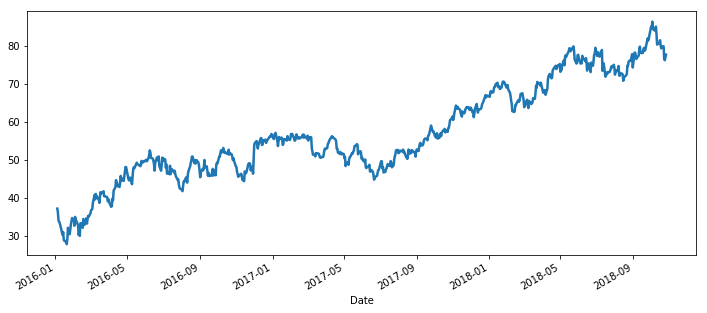

In [17]:
df['Price'].plot(lw=2.5, figsize=(12,5));

In [18]:
%%time

# Instantiating the model using SARIMAX, the optimal p, d, q values, and a seasonal order based on 365 days/year.
model = sm.tsa.statespace.SARIMAX(df['Price'],
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 0, 365),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

# Fitting the model
SARIMAX_results = model.fit()

Wall time: 8min 41s


In [19]:
# Getting model's predictions of the in-sample data, rounding to two decimal places for price.
SARIMAX_predictions = round(SARIMAX_results.predict(), 2)

# Creating a dataframe of the date index and predictions
SARIMAX_preds = pd.DataFrame(list(zip(list(SARIMAX_predictions.index),list(SARIMAX_predictions))),
                             columns=['Date','PredictedPrice']).set_index('Date')

# Merging the original dataframe with predictions for comparison
SARIMAX_predicted_df = pd.merge(df[1:], SARIMAX_preds, left_index=True, right_index=True)

SARIMAX_predicted_df.head()

,Price,PredictedPrice
Date,,
2016-01-05,36.42,37.22
2016-01-06,34.23,36.42
2016-01-07,33.75,34.23
2016-01-08,33.55,33.75
2016-01-11,31.55,33.55


In [20]:
print("\tMean Squared Error:", mean_squared_error(SARIMAX_predicted_df['Price'], 
                                                  SARIMAX_predicted_df['PredictedPrice']))
print("\tRoot Mean Squared Error:", np.sqrt(mean_squared_error(SARIMAX_predicted_df['Price'], 
                                                               SARIMAX_predicted_df['PredictedPrice'])))

	Mean Squared Error: 2.199066712517193
	Root Mean Squared Error: 1.48292505289957


In [21]:
# Getting 6 months for forecasts
SARIMAX_forecast = round(SARIMAX_results.forecast(steps = 120), 2)

# Creating an index from 10/29/2018 to six months out, frequency indicates business day which eliminates weekends and
# US holidays, then putting it all together into a SARIMAX_forecast dataframe
idx = pd.date_range('2018-10-29', '2019-04-14', freq='B')

SARIMAX_forecast = pd.DataFrame(list(zip(list(idx),list(SARIMAX_forecast))),
                             columns=['Date','ForecastPrice']).set_index('Date')

SARIMAX_forecast.head()

,ForecastPrice
Date,
2018-10-29,76.09
2018-10-30,76.41
2018-10-31,75.73
2018-11-01,75.25
2018-11-02,75.90


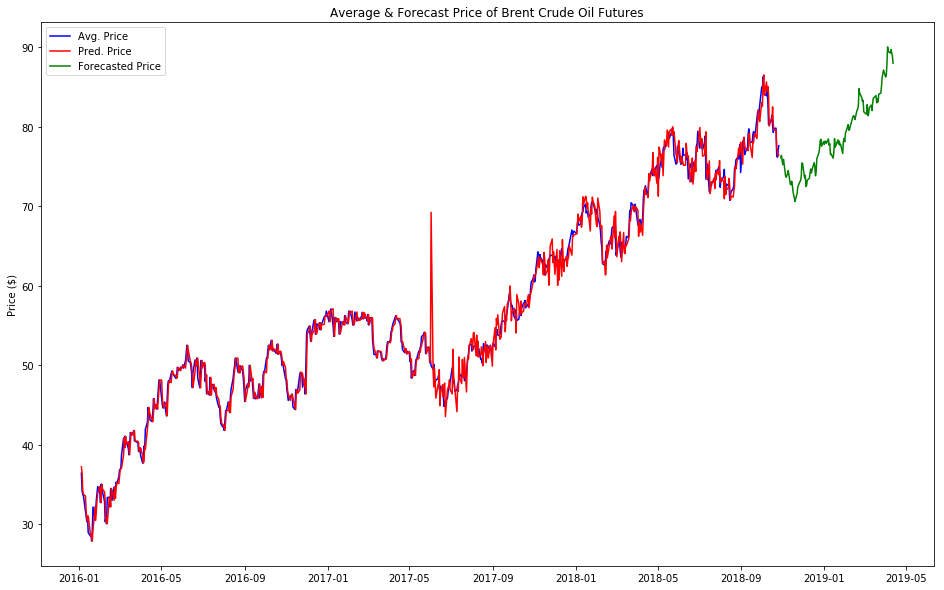

In [22]:
# Matplotlib Plot for Notebook

fig=plt.figure(figsize=[16,10])
fig.show()
ax=fig.add_subplot(111)

ax.plot(SARIMAX_predicted_df['Price'],c='b',label='Avg. Price')
ax.plot(SARIMAX_predicted_df['PredictedPrice'],c='r', label='Pred. Price')
ax.plot(SARIMAX_forecast['ForecastPrice'],c='g', label='Forecasted Price')

plt.legend(loc='best')
plt.ylabel('Price ($)')
plt.title('Average & Forecast Price of Brent Crude Oil Futures')
plt.draw()

In [23]:
trace0 = go.Scatter(
    x = SARIMAX_predicted_df.index,
    y = SARIMAX_predicted_df['Price'],
    mode = 'lines',
    name = 'Daily Price'
)
trace1 = go.Scatter(
    x = SARIMAX_predicted_df.index,
    y = SARIMAX_predicted_df['PredictedPrice'],
    mode = 'lines',
    name = 'Predicted Price'
)
trace2 = go.Scatter(
    x = SARIMAX_forecast.index,
    y = SARIMAX_forecast['ForecastPrice'],
    mode = 'lines',
    name = 'Forecast Price'
)
data = [trace0, trace1, trace2]

layout = go.Layout(
    title = 'SARIMAX Model: Daily & 6-Month Forecast Price of Brent Crude Oil Futures from 2016',
    xaxis = dict(title = 'Date'),
    yaxis = dict(title = 'Price ($)')
) 

fig = go.Figure(data = data, layout = layout)

pyo.plot(fig)

'file://C:\\Users\\aggie\\Projects\\Stock_Trading\\temp-plot.html'

In [24]:
# Plotly graph of Brent Crude dataset from 2016
trace = go.Scatter(x=df.index,
                       y=df['Price'],
                       mode='lines')
data = [trace]

layout = go.Layout(
    title = 'Brent Crude Oil Futures from January, 2016',
    xaxis = dict(title = 'Date'),
    yaxis = dict(title = 'Price ($)')
) 

fig = go.Figure(data = data, layout = layout)

pyo.plot(fig)

'file://C:\\Users\\aggie\\Projects\\Stock_Trading\\temp-plot.html'